In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

from datetime import datetime 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


# Загрузка данных

In [2]:
!pip freeze > requirements.txt
random_seed = 42

data_train = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')
data_test =  pd.read_csv('/kaggle/input/sf-dst-scoring/test.csv')

In [3]:
data_train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [4]:
data_test.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


### Склеивание данных

In [5]:
# разметка
data_train['Train'] = 1 
data_test['Train']  = 0 

data = data_train.append(data_test, sort=False).reset_index(drop=True)

In [6]:
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0,1


In [7]:
print(data_train.shape)
print(data_test.shape)
print(data.shape)

(73799, 20)
(36349, 19)
(110148, 20)


In [8]:
data.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default,Train
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,73799.000000,110148.000000
mean,55074.500000,39.249410,0.273205,0.165514,-1.904535,2.005002,56.751189,1.574945,2.497867,41012.648537,1.731588,2.765570,0.126994,0.669999
std,31797.133063,11.518063,0.799099,0.371645,0.499397,2.266926,13.065923,0.527562,0.687651,45399.735051,1.122652,1.010151,0.332968,0.470215
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000,0.000000
25%,27537.750000,30.000000,0.000000,0.000000,-2.260434,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000,0.000000
50%,55074.500000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000,1.000000
75%,82611.250000,48.000000,0.000000,0.000000,-1.567888,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000,1.000000
max,110148.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000,1.000000


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

# Анализ признаков

#### Признаки:   
<ol>
    <li>client_id - идентификатор клиента</li>
    <li>app_date - дата подачи заявки</li>
    <li>education - уровень образования</li>
    <li>sex - пол заемщика</li>
    <li>age - возраст заемщика</li>
    <li>car - флаг наличия автомобиля</li>
    <li>car_type - флаг автомобиля иномарки</li>
    <li>decline_app_cnt - количество отказанных прошлых заявок</li>
    <li>good_work - флаг наличия “хорошей” работы</li>
    <li>score_bki - скоринговый балл по данным из БКИ</li>
    <li>bki_request_cnt - количество запросов в БКИ</li>
    <li>region_rating - рейтинг региона</li>
    <li>home_address - категоризатор домашнего адреса</li>
    <li>work_address - категоризатор рабочего адреса</li>
    <li>income - доход заемщика</li>
    <li>sna - связь заемщика с клиентами банка</li>
    <li>foreign_passport - наличие загранпаспорта</li>
    <li>default - наличие дефолта - <i><b>Целевая переменная</b><i></li>
</ol>


### Проруски

In [10]:
data.isna().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
Train                   0
dtype: int64

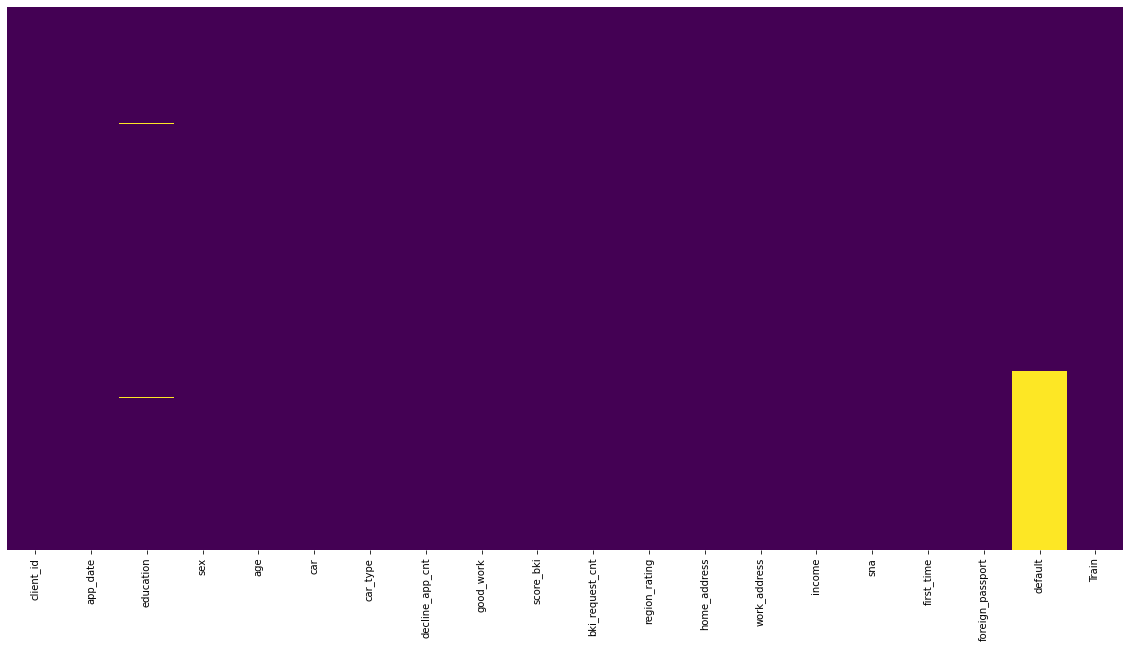

In [11]:
fig, ax = plt.subplots(figsize=(20,10))
sns_heatmap = sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

### Временной признак 'app_date'

In [12]:
data.app_date = pd.to_datetime(data.app_date, format='%d%b%Y')
 
data['day_count'] = (data.app_date - pd.to_datetime('23/12/2013')).dt.days.astype('int')
data['day_count'] 

0          40
1          79
2          40
3          31
4         116
         ... 
110143     98
110144    123
110145     97
110146     15
110147     84
Name: day_count, Length: 110148, dtype: int64

### Признак 'education'[](http://)

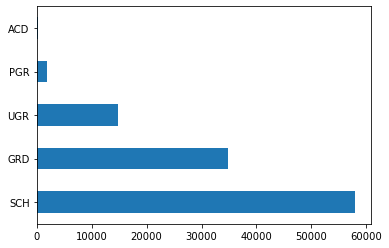

In [13]:
data.education.value_counts().plot.barh()

In [14]:
# Общее количество пропусков
data['education'].isna().sum()

478

In [15]:
data['education'].value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

In [16]:
data['education'] = data['education'].fillna(data['education'].value_counts().index[0])
data['education'].isna().sum()

0

### Группируем столбцы по типу признаков

In [17]:
# time_cols = ['app_date']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income', 'day_count']

## Числовые признаки

### Распределение и выбросы

In [18]:
# фиксируем параметры графиков
sns.set(rc={'figure.figsize':(7,5)}, font_scale=1, style='whitegrid')

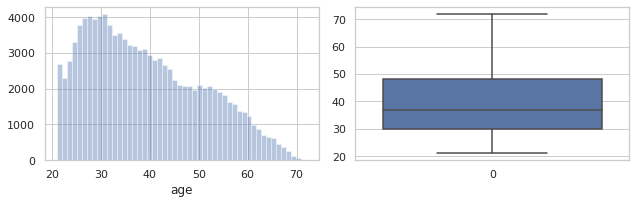

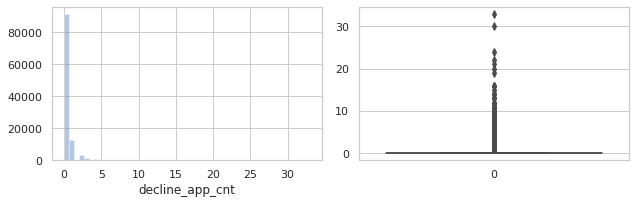

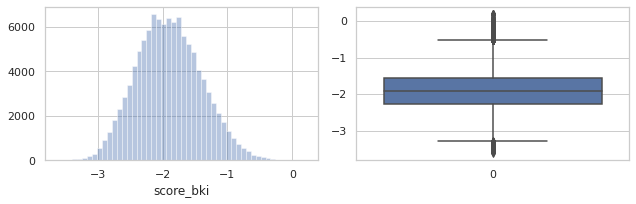

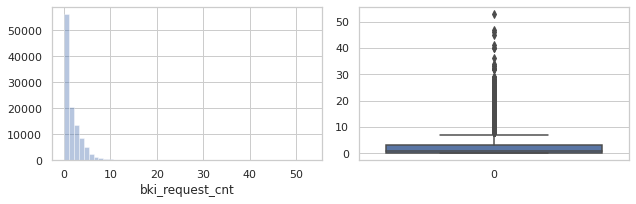

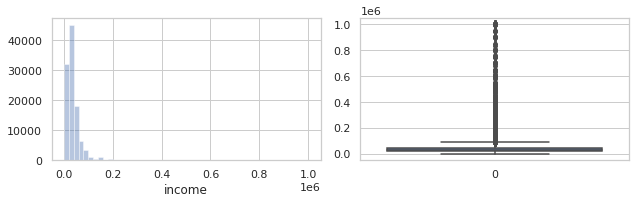

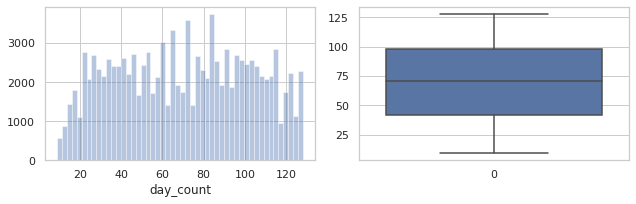

In [19]:
# обернуть в функцию
# sns.axes_style("white")
for i in num_cols:
    fig = plt.figure(figsize=(9, 3))
    gs = fig.add_gridspec(1, 2)
        
    ax = fig.add_subplot(gs[0, 0])
    sns.distplot(data[i], kde = False, rug=False)

    ax = fig.add_subplot(gs[0, 1])
    sns.boxplot(data=data[i])

    fig.tight_layout()

### Корреляция

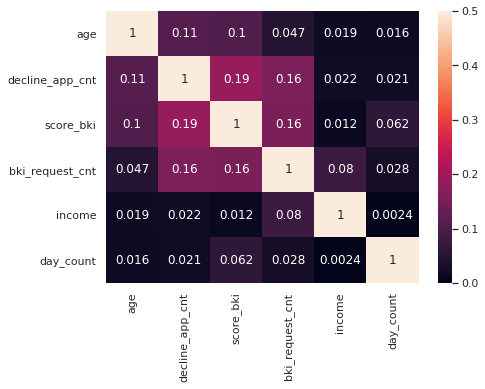

In [20]:
sns.heatmap(data[num_cols].corr().abs(), annot = True, vmin=0, vmax=0.5)

## Значимость непрерывных переменных

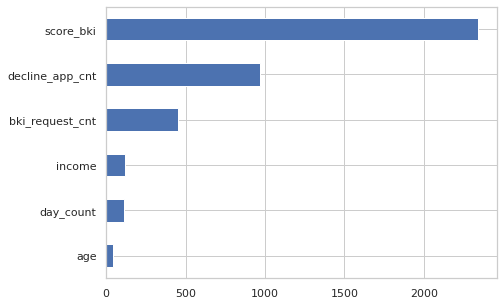

In [21]:
df = data.query('Train == 1')
imp_num = pd.Series(f_classif(df[num_cols], df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

# Бинарные переменные

In [22]:
data[bin_cols].head()

,sex,car,car_type,good_work,foreign_passport
0,M,Y,Y,0,N
1,F,N,N,0,N
2,M,Y,N,0,Y
3,F,N,N,0,N
4,M,N,N,1,Y


In [23]:
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(data['sex']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'F', 1: 'M'}


In [24]:
for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
# убедимся в преобразовании    
data[bin_cols].head()

,sex,car,car_type,good_work,foreign_passport
0,1,1,1,0,0
1,0,0,0,0,0
2,1,1,0,0,1
3,0,0,0,0,0
4,1,0,0,1,1


# Категориальные признаки

In [25]:
data[cat_cols].head(3)

,education,region_rating,home_address,work_address,sna,first_time
0,SCH,50,1,2,4,1
1,SCH,50,2,3,4,1
2,SCH,80,1,2,1,4


### Перекодируем столбец 'education'

In [26]:
edu_lvl = {}
data['education'].value_counts().index
for i,val in enumerate(data['education'].value_counts().index):
    edu_lvl[val] = i
edu_lvl

data['education'] = data['education'].apply(lambda lvl: edu_lvl[lvl])
data['education'].value_counts().index

Int64Index([0, 1, 2, 3, 4], dtype='int64')

In [27]:
data[cat_cols].head(3)

,education,region_rating,home_address,work_address,sna,first_time
0,0,50,1,2,4,1
1,0,50,2,3,4,1
2,0,80,1,2,1,4


## Визуализация категориальных переменных

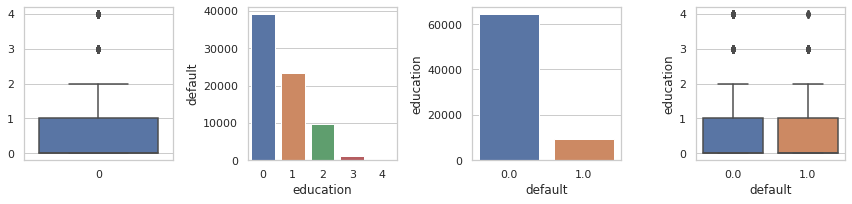

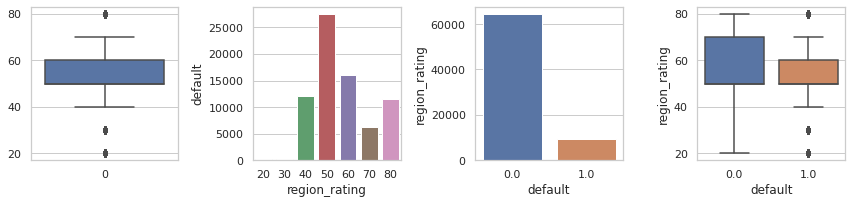

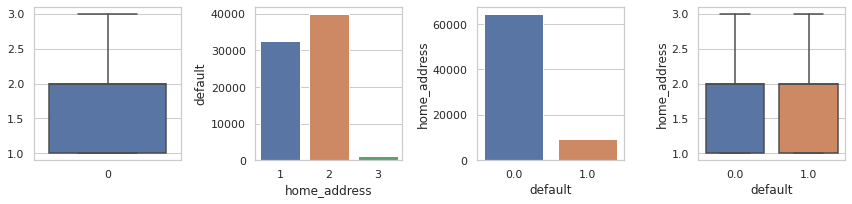

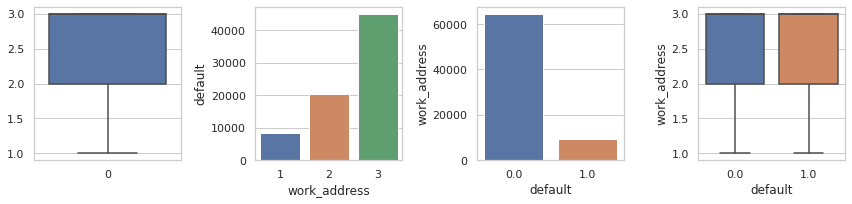

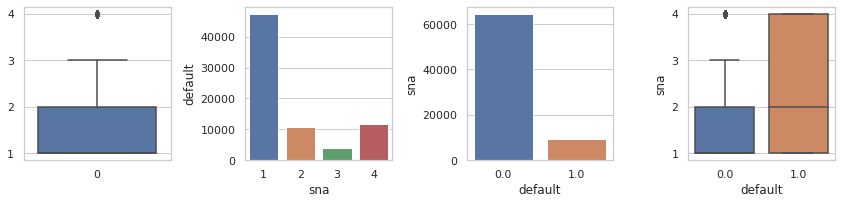

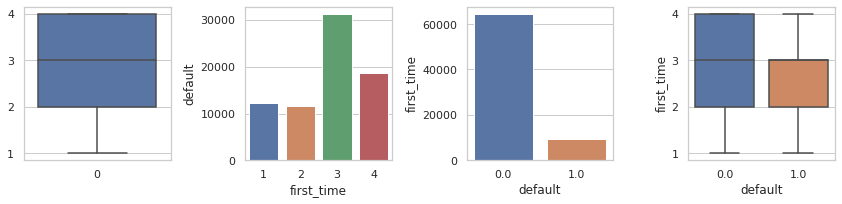

In [28]:
# обернуть в функцию
df = data.query('Train == 1')

for col in cat_cols:
    
    fig = plt.figure(figsize=(12, 3))
    gsp = fig.add_gridspec(1, 4)
    
    ax = fig.add_subplot(gsp[0, 0])
    sns.boxplot(data=df[col])
    
    ax = fig.add_subplot(gsp[0, 1])
    sns.barplot(x=col, y='default', data=df, estimator=len)
        

    ax = fig.add_subplot(gsp[0, 2])
    sns.barplot(x='default', y=col, data=df, estimator=len)


    ax = fig.add_subplot(gsp[0, 3])
    sns.boxplot(x='default', y=col, data=df)

    fig.tight_layout()

## Значимость категориальных признаков

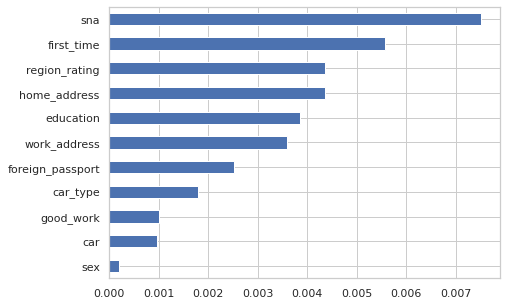

In [29]:
imp_cat = pd.Series(mutual_info_classif(df[bin_cols + cat_cols], df['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

# Подготовка данных к машинному обучению

In [30]:
data = pd.get_dummies(data, prefix=cat_cols, columns=cat_cols)

In [31]:
data.drop(['app_date', 'client_id'], axis=1, inplace=True)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 39 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sex               110148 non-null  int64  
 1   age               110148 non-null  int64  
 2   car               110148 non-null  int64  
 3   car_type          110148 non-null  int64  
 4   decline_app_cnt   110148 non-null  int64  
 5   good_work         110148 non-null  int64  
 6   score_bki         110148 non-null  float64
 7   bki_request_cnt   110148 non-null  int64  
 8   income            110148 non-null  int64  
 9   foreign_passport  110148 non-null  int64  
 10  default           73799 non-null   float64
 11  Train             110148 non-null  int64  
 12  day_count         110148 non-null  int64  
 13  education_0       110148 non-null  uint8  
 14  education_1       110148 non-null  uint8  
 15  education_2       110148 non-null  uint8  
 16  education_3       11

### Масштабирование данны

In [33]:
scaler = RobustScaler()

data[num_cols] = scaler.fit_transform(data[num_cols].values)

## Разбиение выбрки

In [34]:
train_data = data.query('Train == 1').drop(['Train'], axis=1)
test_data  = data.query('Train == 1').drop(['Train'], axis=1)
     
X = train_data.drop(['default'], axis=1).values
y = train_data.default.values  

In [35]:
# Из train выделяем данные на валидацию 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=random_seed)
test_data.shape, train_data.shape, X.shape, X_train.shape, X_valid.shape

((73799, 38), (73799, 38), (73799, 37), (59039, 37), (14760, 37))

# Машинное обучение

In [36]:
model = LogisticRegression(random_state=random_seed, max_iter = 1000)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_valid)[:,1]
y_pred = model.predict(X_valid)

### Метрики

In [37]:
# Метрики
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_prob)
Accuracy_1 = accuracy_score(y_valid, y_pred)
Precision_1 = precision_score(y_valid, y_pred)
Recall_1 = recall_score(y_valid, y_pred)
F1_1 = f1_score(y_valid, y_pred)
ROC_AUC_1 = round(roc_auc_score(y_valid, y_pred_prob), 4)
PRC_AUC_1 = round(auc(recall, precision), 4)

### Кривая ROC-AUC

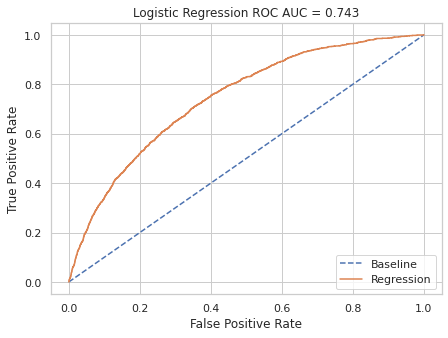

In [38]:
fpr, tpr, threshold = roc_curve(y_valid, y_pred_prob)
roc_auc = roc_auc_score(y_valid, y_pred_prob)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [39]:
TN, FP, FN, TP = confusion_matrix(y_valid, y_pred).ravel()
conf_matrix = [[TP, FP],[FN, TN]]

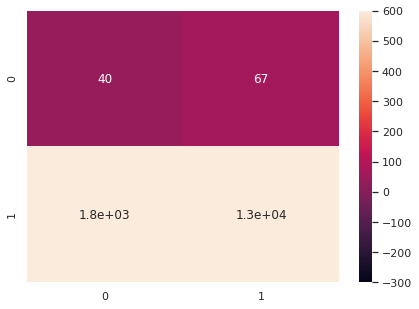

In [40]:
sns.heatmap(conf_matrix, annot = True, vmin=-300, vmax=600)

In [41]:
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_prob)

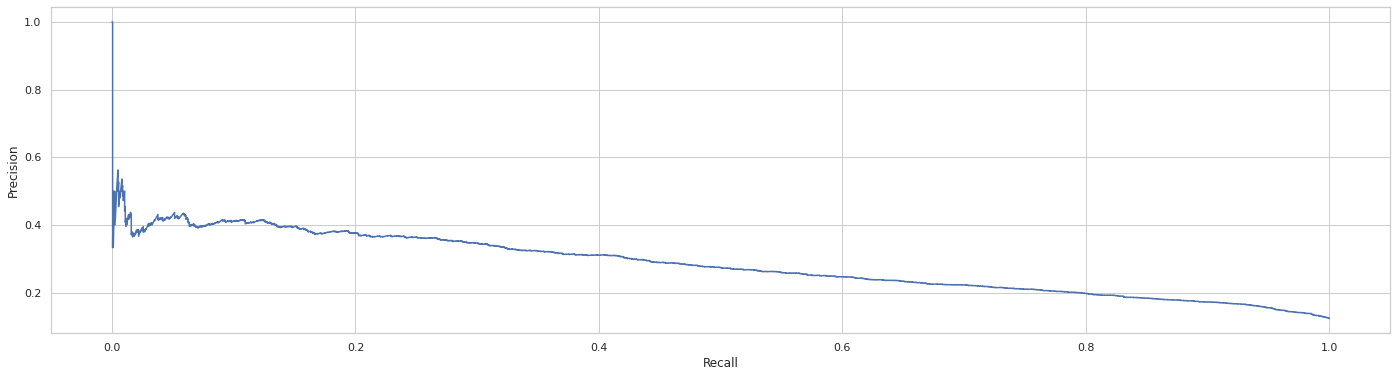

In [42]:
plt.figure(figsize=(24, 6))
plt.plot(recall, precision)
    
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [43]:
# Метрики
Accuracy_1 = accuracy_score(y_valid, y_pred)
print('Accuracy_1: %.4f' % Accuracy_1)
Precision_1 = precision_score(y_valid, y_pred)
print('Precision_1: %.4f' % Precision_1)
Recall_1 = recall_score(y_valid, y_pred)
print('Recall_1: %.4f' % Recall_1)
F1_1 = f1_score(y_valid, y_pred)
print('F1_1: %.4f' % F1_1)
ROC_AUC_1 = round(roc_auc_score(y_valid, y_pred_prob), 4)
print('ROC_AUC_1 = ', ROC_AUC_1)
PRC_AUC_1 = round(auc(recall, precision), 4)
print('PRC_AUC_1 = ', PRC_AUC_1)

Accuracy_1: 0.8744
Precision_1: 0.3738
Recall_1: 0.0219
F1_1: 0.0414
ROC_AUC_1 =  0.7427
PRC_AUC_1 =  0.2829


## Оптимизация параметров

In [44]:
model = LogisticRegression(random_state=random_seed)
iter_val = 50  
param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_val]},
    
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_val]},
    
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_val]},
]

gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
print(model)


LogisticRegression(class_weight='balanced', max_iter=50, random_state=42,
                   solver='liblinear')


In [45]:
model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_valid)[:,1]
y_pred = model.predict(X_valid)

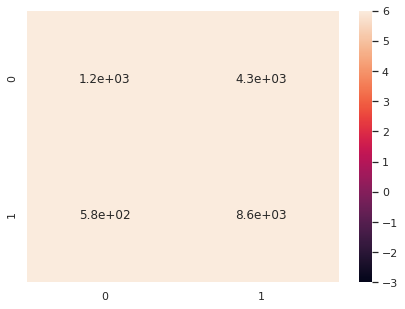

In [46]:
# матрица ошибок
TN, FP, FN, TP = confusion_matrix(y_valid, y_pred).ravel()
conf_matrix = [[TP, FP],[FN, TN]]
sns.heatmap(conf_matrix, annot = True, vmin=-3, vmax=6)

In [47]:
print('Старые значения метрик:')
print('Accuracy_1: %.4f' % Accuracy_1)
print('Precision_1: %.4f' % Precision_1)
print('Recall_1: %.4f' % Recall_1)
print('F1_1: %.4f' % F1_1)
print('ROC_AUC_1 = ', ROC_AUC_1)
print('PRC_AUC_1 = ', PRC_AUC_1)
print('\nНовые значения метрик:')
print('Accuracy: %.4f' % accuracy_score(y_valid, y_pred))
print('Precision: %.4f' % precision_score(y_valid, y_pred))
print('Recall: %.4f' % recall_score(y_valid, y_pred))
print('F1: %.4f' % f1_score(y_valid, y_pred))
print('ROC_AUC = ', round(roc_auc_score(y_valid, y_pred_prob), 4))
print('PRC_AUC = ', round(auc(recall, precision), 4))

Старые значения метрик:
Accuracy_1: 0.8744
Precision_1: 0.3738
Recall_1: 0.0219
F1_1: 0.0414
ROC_AUC_1 =  0.7427
PRC_AUC_1 =  0.2829

Новые значения метрик:
Accuracy: 0.6694
Precision: 0.2249
Recall: 0.6831
F1: 0.3384
ROC_AUC =  0.7422
PRC_AUC =  0.2829


# Submission

In [48]:
train_data = data.query('Train == 1').drop(['Train'], axis=1)
test_data =  data.query('Train == 0').drop(['Train'], axis=1)

In [49]:
X_train=train_data.drop(['default'], axis=1)
y_train = train_data.default.values
X_test = test_data.drop(['default'], axis=1)

In [50]:
test_data.shape, train_data.shape, X_train.shape, y_train.shape, X_test.shape

((36349, 38), (73799, 38), (73799, 37), (73799,), (36349, 37))

In [51]:
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=50, random_state=42,
                   solver='liblinear')

In [52]:
y_pred_prob = model.predict_proba(X_test)[:,1]

submit = pd.DataFrame(data_test.client_id)

submit['default'] = y_pred_prob

submit.to_csv('submission.csv', index=False)

submit.head()

,client_id,default
0,74835,0.192887
1,17527,0.800288
2,75683,0.301899
3,26883,0.403569
4,28862,0.151837
